# Lesson 1: Introduction to Deep Learning with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

### What is PyTorch ?

### Why PyTorch ?

### Code

In [58]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

%matplotlib inline
plt.style.use('fivethirtyeight')

In [59]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

### Create the data

In [60]:
seed=12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000 # num_samples_per_class
D = 2 # dimensions
C = 4 # num_classes
H = 100 # num_hidden_units

In [61]:
X = torch.zeros((N*C, D))
y = torch.zeros((N*C))
for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(i*4,(i+1)*4,N) + torch.randn(N)*0.1
    for ix in range(N*i, N*(i+1)):
        X[ix] = torch.FloatTensor(
            (r[index]*np.sin(t[index]), r[index]*np.cos(t[index])), )
        y[ix] = i
        index += 1

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([4000, 2])
y: torch.Size([4000])


In [62]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show ()

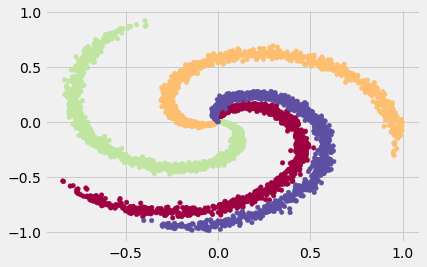

In [63]:
# Create the data
plot_data(X.numpy(), y.numpy())

### Create train/test sets

In [79]:
split_ratio = 0.8 # train-test split
num_epochs = 100
batch_size = 64
log_every = 25

In [80]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 3200 train samples and 800 test samples.


In [81]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [82]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Processing functions

In [83]:
def process_batch(batch, model, criterion, optimizer, is_training, clipping=False):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        if clipping:
            # Clip the gradient norms
            nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [84]:
def train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2):
    """
    Training our model.
    """
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy    

        # Verbose
        if (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1):

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [85]:
def hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training, clipping=True)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
        if animate:
            verbose_condition = num_train_epoch == num_epochs-1
            if num_train_epoch%10 == 0:
                plot_model(X, y, model)
                display.clear_output(wait=True)
        else:
            verbose_condition = (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

        # Verbose
        if verbose_condition:

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training, clipping=True)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [86]:
def plot_model(X, y, model):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

### Linear model

In [87]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [88]:
# Linear model
class LinearModel(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

In [89]:
# Create model
model = LinearModel(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

TIME REMAINING: 0m 3s
[EPOCH]: 0, [TRAIN LOSS]: 0.019323, [TRAIN ACC]: 0.400, [TEST LOSS]: 0.019253, [TEST ACC]: 0.392
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.016286, [TRAIN ACC]: 0.400, [TEST LOSS]: 0.017569, [TEST ACC]: 0.399
TIME REMAINING: 0m 1s
[EPOCH]: 50, [TRAIN LOSS]: 0.016283, [TRAIN ACC]: 0.397, [TEST LOSS]: 0.017569, [TEST ACC]: 0.397
TIME REMAINING: 0m 0s
[EPOCH]: 75, [TRAIN LOSS]: 0.016281, [TRAIN ACC]: 0.397, [TEST LOSS]: 0.017569, [TEST ACC]: 0.389
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.016278, [TRAIN ACC]: 0.394, [TEST LOSS]: 0.017569, [TEST ACC]: 0.389


LinearModel (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
)


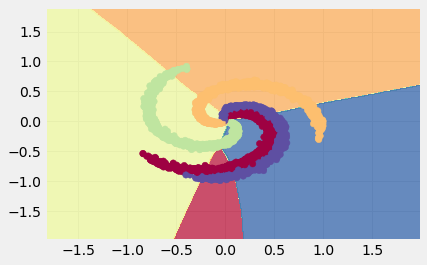

In [90]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Two-layered Network

In [91]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [92]:
# Linear model
class NN(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(NN, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z

In [93]:
# Create model
model = NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

TIME REMAINING: 0m 3s
[EPOCH]: 0, [TRAIN LOSS]: 0.021009, [TRAIN ACC]: 0.364, [TEST LOSS]: 0.021108, [TEST ACC]: 0.405
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.007562, [TRAIN ACC]: 0.828, [TEST LOSS]: 0.008497, [TEST ACC]: 0.793
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.004543, [TRAIN ACC]: 0.928, [TEST LOSS]: 0.005300, [TEST ACC]: 0.927
TIME REMAINING: 0m 0s
[EPOCH]: 75, [TRAIN LOSS]: 0.003097, [TRAIN ACC]: 0.958, [TEST LOSS]: 0.003735, [TEST ACC]: 0.953
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002300, [TRAIN ACC]: 0.973, [TEST LOSS]: 0.002878, [TEST ACC]: 0.966


NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
)


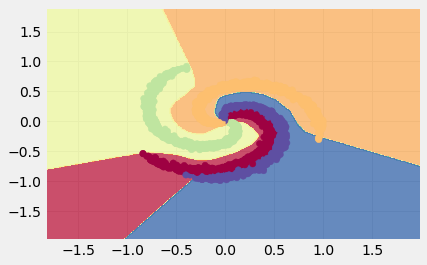

In [94]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Custom Components

In [95]:
learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

In [96]:
# Linear model
class NN2(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(dropout_p)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [97]:
# Create model
model = NN2(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm)

TIME REMAINING: 0m 4s
[EPOCH]: 0, [TRAIN LOSS]: 0.021055, [TRAIN ACC]: 0.346, [TEST LOSS]: 0.021972, [TEST ACC]: 0.413
TIME REMAINING: 0m 3s
[EPOCH]: 25, [TRAIN LOSS]: 0.011709, [TRAIN ACC]: 0.647, [TEST LOSS]: 0.012474, [TEST ACC]: 0.617
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.008999, [TRAIN ACC]: 0.779, [TEST LOSS]: 0.009407, [TEST ACC]: 0.772
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.007765, [TRAIN ACC]: 0.824, [TEST LOSS]: 0.007872, [TEST ACC]: 0.849
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.006744, [TRAIN ACC]: 0.859, [TEST LOSS]: 0.006792, [TEST ACC]: 0.892


NN2 (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
  (dropout): Dropout (p = 0.1)
)


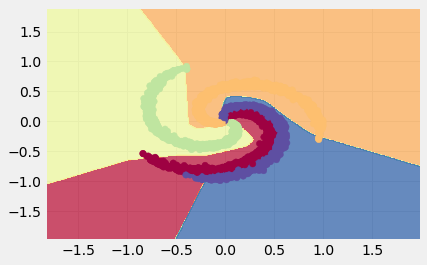

In [98]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Custom autograd

In [99]:
class ReLU(torch.autograd.Function):
    """
    Use autograd variables for implicit 
    backprop and make your own autograd 
    func. Just implemnet forward and 
    backward pass.
    """

    def forward(self, input_):
        """
        Process inputs and use
        save_for_backward to store
        inputs for backprop.
        """
        self.save_for_backward(input_)
        return input_.clamp(min=0)

    def backward(self, grad_output):
        """
        grad_output is the grad w.r.t loss.
        """
        input_, =self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_ < 0] = 0
        return grad_input

In [100]:
# custom autograd func.
relu = ReLU()

# Forward pass
h = Variable(torch.ones((2,3)), requires_grad=True)
h_relu = relu(h)

### Save/load models

In [101]:
# Save the model
torch.save(model, os.path.join("model-NN2.pt"))

/Users/Goku/Documents/opt/venv/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type NN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [102]:
# Load the model
model = torch.load(os.path.join("model-NN2.pt"))

### Inference

In [103]:
X_infer = Variable(X[0].view(1, -1))
y_infer = Variable(y[:1])
print ("X_infer:\n", X_infer)
print ("y_infer:\n", y_infer)

X_infer:
 Variable containing:
-0.1287 -0.0103
[torch.FloatTensor of size 1x2]

y_infer:
 Variable containing:
 1
[torch.FloatTensor of size 1]



In [104]:
# Feed through model
model.eval()
scores = model(X_infer)
probabilities = F.softmax(scores)

# Sorted probabilities
sorted_, indices = torch.sort(probabilities, descending=True)
for i, index in enumerate(indices[0]):
    print ("%i - %i%%" % (
        indices[0].data[i],
        100.0*probabilities.data[0][index.data[0]]))

1 - 58%
2 - 25%
0 - 8%
3 - 7%


### Hyperparameters

Let's see how changing our hyperparameters can alter the model.

TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.005969, [TRAIN ACC]: 0.868, [TEST LOSS]: 0.006058, [TEST ACC]: 0.899
NN2 (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
  (dropout): Dropout (p = 0.1)
)


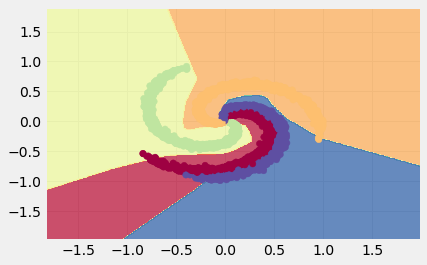

In [105]:
model = NN2(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=True)
# Plot trained model
print (model)
plot_model(X, y, model)

### Visualization / debugging

### Caution

More data we have, the larger we can make our models and not suffer from overfitting. Things like dropout and finetuning regularization etc. will help us with getting better generalization but we still need to very cautious. In fact, with enough parameters, we can overfit to **completely random data**...

```
FINITE-SAMPLE EXPRESSIVITY:

"There exists a two-layer neural network with ReLU activations and 2n+d weights that can represent any function on a sample of size n in d dimensions”. This really demonstrates the brute-force capacity of neural nets for any dataset. The proof can be found in the appendix of https://arxiv.org/abs/1611.03530.
```

In [135]:
N = 1000
C = 3
H = 300
X = torch.randn(N*C, D)
y = torch.FloatTensor([[i]*N for i in range(C)]).view(-1)

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([3000, 2])
y: torch.Size([3000])


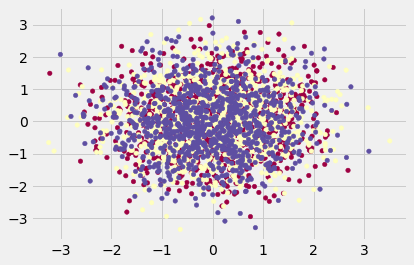

In [136]:
# Create the data
plot_data(X.numpy(), y.numpy())

In [137]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

We have 2400 train samples and 600 test samples.


In [ ]:
model = NN2(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

num_epochs = 1000
log_every = 100
learning_rate = 1e-1
lambda_l2 = 0
dropout_p = 0.1
decay_rate = 1
max_grad_norm = 5.0

model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)
# Plot trained model
print (model)
plot_model(X, y, model)

TIME REMAINING: 0m 49s
[EPOCH]: 0, [TRAIN LOSS]: 0.023648, [TRAIN ACC]: 0.338, [TEST LOSS]: 0.021558, [TEST ACC]: 0.357
TIME REMAINING: 0m 40s
[EPOCH]: 100, [TRAIN LOSS]: 0.017681, [TRAIN ACC]: 0.320, [TEST LOSS]: 0.020022, [TEST ACC]: 0.344
TIME REMAINING: 0m 36s
[EPOCH]: 200, [TRAIN LOSS]: 0.017681, [TRAIN ACC]: 0.320, [TEST LOSS]: 0.020022, [TEST ACC]: 0.344
